# 1. Import data and library

### Import data and model metrics

In [15]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
#for nlp-based cl
import nltk
from nltk.corpus import stopwords
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import fpgrowth
import scipy.sparse as sparse
from lightfm import LightFM # model
from lightfm.evaluation import precision_at_k
from lightfm.cross_validation import random_train_test_split

In [16]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.

    This function computes the average prescision at k between two lists of
    items.

    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The average precision at k over the input lists

    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.

    This function computes the mean average prescision at k between two lists
    of lists of items.

    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The mean average precision at k over the input lists

    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [17]:
# https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/308635
def customer_hex_id_to_int(series):
    return series.str[-16:].apply(hex_id_to_int)

def hex_id_to_int(str):
    return int(str[-16:], 16)

def article_id_str_to_int(series):
    return series.astype('int32')

def article_id_int_to_str(series):
    return '0' + series.astype('str')

class Categorize(BaseEstimator, TransformerMixin):
    def __init__(self, min_examples=0):
        self.min_examples = min_examples
        self.categories = []
        
    def fit(self, X):
        for i in range(X.shape[1]):
            vc = X.iloc[:, i].value_counts()
            self.categories.append(vc[vc > self.min_examples].index.tolist())
        return self

    def transform(self, X):
        data = {X.columns[i]: pd.Categorical(X.iloc[:, i], categories=self.categories[i]).codes for i in range(X.shape[1])}
        return pd.DataFrame(data=data)


def calculate_apk(list_of_preds, list_of_gts):
    # for fast validation this can be changed to operate on dicts of {'cust_id_int': [art_id_int, ...]}
    # using 'data/val_week_purchases_by_cust.pkl'
    apks = []
    for preds, gt in zip(list_of_preds, list_of_gts):
        apks.append(apk(gt, preds, k=12))
    return np.mean(apks)

def eval_sub(sub_csv, skip_cust_with_no_purchases=True):
    sub=pd.read_csv(sub_csv)
    validation_set=pd.read_parquet('data/validation_ground_truth.parquet')

    apks = []

    no_purchases_pattern = []
    for pred, gt in zip(sub.prediction.str.split(), validation_set.prediction.str.split()):
        if skip_cust_with_no_purchases and (gt == no_purchases_pattern): continue
        apks.append(apk(gt, pred, k=12))
    return np.mean(apks)

### Import data

In [185]:
%time

transactions = pd.read_parquet('transactions_train.parquet')
customers = pd.read_parquet('customers.parquet')
articles = pd.read_parquet('articles.parquet')

# sample = 0.05
# transactions = pd.read_parquet(f'data/transactions_train_sample_{sample}.parquet')
# customers = pd.read_parquet(f'data/customers_sample_{sample}.parquet')
# articles = pd.read_parquet(f'data/articles_train_sample_{sample}.parquet')

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.87 µs


In [186]:
#test data -> the week next to the most recent week
#subset the transactions data in the past 10 weeks for training
test_week = transactions.week.max() + 1
transactions = transactions[transactions.week > transactions.week.max() - 10]

# Generating candidates - Recall


### Last purchase candidates

In [187]:
%%time
#orders in past 5 weeks group by week and customer_id 
c2weeks = transactions.groupby('customer_id')['week'].unique()

CPU times: user 15.4 s, sys: 921 ms, total: 16.3 s
Wall time: 15.8 s


In [188]:
# the time interval in each week
transactions.groupby('week')['t_dat'].agg(['min', 'max'])

,min,max
week,,
95,2020-07-15,2020-07-21
96,2020-07-22,2020-07-28
97,2020-07-29,2020-08-04
98,2020-08-05,2020-08-11
99,2020-08-12,2020-08-18
100,2020-08-19,2020-08-25
101,2020-08-26,2020-09-01
102,2020-09-02,2020-09-08
103,2020-09-09,2020-09-15


In [189]:
c2weeks

customer_id
28847241659200          [95, 96, 101, 102]
41318098387474                        [98]
116809474287335                 [101, 103]
200292573348128          [95, 96, 99, 102]
248294615847351                       [96]
                               ...        
18446624797007271432                  [95]
18446630855572834764                 [103]
18446662237889060501                 [100]
18446705133201055310                 [102]
18446737527580148316                 [104]
Name: week, Length: 437365, dtype: object

In [190]:
%%time
#use a hashmap to store: a key: customer_id and a value: a hashmap where the key is the current_week and the value is week of the next purchase 
#the last one is a test week
c2weeks2shifted_weeks = {}

for c_id, weeks in c2weeks.items():
    c2weeks2shifted_weeks[c_id] = {}
    for i in range(weeks.shape[0]-1):
        c2weeks2shifted_weeks[c_id][weeks[i]] = weeks[i+1]
    c2weeks2shifted_weeks[c_id][weeks[-1]] = test_week

CPU times: user 614 ms, sys: 539 ms, total: 1.15 s
Wall time: 2.4 s


In [191]:
candidates_last_purchase = transactions.copy()

In [192]:
%%time
# for each of combination of customer_id and week, append the next purchase week to weeks
weeks = []
for i, (c_id, week) in enumerate(zip(transactions['customer_id'], transactions['week'])):
    weeks.append(c2weeks2shifted_weeks[c_id][week])
    
candidates_last_purchase.week=weeks

CPU times: user 7.05 s, sys: 189 ms, total: 7.24 s
Wall time: 7.5 s


### Bestsellers candidates

In [193]:
#average purchase price group by week and article id 
mean_price = transactions \
    .groupby(['week', 'article_id'])['price'].mean()

In [194]:
mean_price

week  article_id
95    108775015     0.004729
      108775044     0.008458
      110065001     0.006085
      110065002     0.006085
      111565001     0.004288
                      ...   
104   952267001     0.013732
      952938001     0.048651
      953450001     0.016932
      953763001     0.021885
      956217002     0.059068
Name: price, Length: 196880, dtype: float32

In [195]:
#rank the 12 best sellers in each week
sales = transactions \
    .groupby('week')['article_id'].value_counts() \
    .groupby('week').rank(method='dense', ascending=False) \
    .groupby('week').head(12).rename('bestseller_rank').astype('int8')

In [196]:
sales

week  article_id
95    760084003      1
      866731001      2
      600886001      3
      706016001      4
      372860002      5
                    ..
104   915529003      8
      915529005      9
      448509014     10
      762846027     11
      714790020     12
Name: bestseller_rank, Length: 120, dtype: int8

In [197]:
bestsellers_previous_week = pd.merge(sales, mean_price, on=['week', 'article_id']).reset_index()
bestsellers_previous_week.week += 1

In [198]:
#combine with the average price
bestsellers_previous_week.pipe(lambda df: df[df['week']==96])

,week,article_id,bestseller_rank,price
0,96,760084003,1,0.025094
1,96,866731001,2,0.024919
2,96,600886001,3,0.022980
3,96,706016001,4,0.033197
4,96,372860002,5,0.013193
5,96,610776002,6,0.008318
6,96,877278002,7,0.025036
7,96,547780003,8,0.024814
8,96,817354001,9,0.021913
9,96,827968001,10,0.016436


In [199]:
# get the uniques transactions in each week
unique_transactions = transactions \
    .groupby(['week', 'customer_id']) \
    .head(1) \
    .drop(columns=['article_id', 'price']) \
    .copy()

In [200]:
unique_transactions

,t_dat,customer_id,sales_channel_id,week
29030503,2020-07-15,272412481300040,1,95
29064059,2020-07-15,1456826891333599,1,95
29067103,2020-07-15,2133687643102426,2,95
29027487,2020-07-15,6010692573790711,1,95
29046403,2020-07-15,6171059100114610,2,95
...,...,...,...,...
31760188,2020-09-22,18435221511488011015,1,104
31782234,2020-09-22,18436859303155335645,1,104
31787251,2020-09-22,18437941771381362708,2,104
31776022,2020-09-22,18438270306572912089,1,104


In [201]:
#dorp any duplicates for week and customer_id 
transactions.drop_duplicates(['week', 'customer_id'])

,t_dat,customer_id,article_id,price,sales_channel_id,week
29030503,2020-07-15,272412481300040,778064028,0.008458,1,95
29064059,2020-07-15,1456826891333599,888294001,0.013542,1,95
29067103,2020-07-15,2133687643102426,843642001,0.042356,2,95
29027487,2020-07-15,6010692573790711,857812010,0.039661,1,95
29046403,2020-07-15,6171059100114610,815447007,0.006763,2,95
...,...,...,...,...,...,...
31760188,2020-09-22,18435221511488011015,573085055,0.033881,1,104
31782234,2020-09-22,18436859303155335645,801447001,0.030492,1,104
31787251,2020-09-22,18437941771381362708,907188001,0.050831,2,104
31776022,2020-09-22,18438270306572912089,751471043,0.033881,1,104


In [202]:
#candidate bestsellers -> unique transactions + best sellers in previous week
candidates_bestsellers = pd.merge(
    unique_transactions,
    bestsellers_previous_week,
    on='week'
)

In [203]:
#create test set transactions -> drop duplicates customer_id, week = test week -> the unique set of customer in final weeks
test_set_transactions = unique_transactions.drop_duplicates('customer_id').reset_index(drop=True)
test_set_transactions.week = test_week

In [204]:
#get the customer set in test week 
test_set_transactions

,t_dat,customer_id,sales_channel_id,week
0,2020-07-15,272412481300040,1,105
1,2020-07-15,1456826891333599,1,105
2,2020-07-15,2133687643102426,2,105
3,2020-07-15,6010692573790711,1,105
4,2020-07-15,6171059100114610,2,105
...,...,...,...,...
437360,2020-09-22,18410229429441241008,2,105
437361,2020-09-22,18417769707947924979,2,105
437362,2020-09-22,18418054986721795659,2,105
437363,2020-09-22,18421175435799911749,2,105


In [205]:
#outer join two tables -> create candidates bestsellers in test week 
candidates_bestsellers_test_week = pd.merge(
    test_set_transactions,
    bestsellers_previous_week,
    on='week'
)

In [206]:
candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_test_week])
candidates_bestsellers.drop(columns='bestseller_rank', inplace=True)

In [207]:
candidates_bestsellers

,t_dat,customer_id,sales_channel_id,week,article_id,price
0,2020-07-22,200292573348128,2,96,760084003,0.025094
1,2020-07-22,200292573348128,2,96,866731001,0.024919
2,2020-07-22,200292573348128,2,96,600886001,0.022980
3,2020-07-22,200292573348128,2,96,706016001,0.033197
4,2020-07-22,200292573348128,2,96,372860002,0.013193
...,...,...,...,...,...,...
5248375,2020-09-22,18438270306572912089,1,105,915529003,0.033439
5248376,2020-09-22,18438270306572912089,1,105,915529005,0.033417
5248377,2020-09-22,18438270306572912089,1,105,448509014,0.041630
5248378,2020-09-22,18438270306572912089,1,105,762846027,0.025005


### LightFM (Light Factorization machine)

In [208]:
lightfm_recomm = pd.read_parquet('lightfm_recomm.parquet')

In [518]:
from lightfm import LightFM
from lightfm.data import Dataset

# default number of recommendations
K = 5
EPOCHS = 10

# model learning rate
LEARNING_RATE = 0.25
# no of latent factors
NO_COMPONENTS = 20

# no of threads to fit model
NO_THREADS = 32
# regularisation for both user and item features
ITEM_ALPHA=1e-6
USER_ALPHA=1e-6
SEED = 42
np.random.seed(SEED)

In [465]:
#create lightFM dataset
dataset = Dataset()
dataset.fit(users=customers['customer_id'], 
            items=articles['article_id'])

num_users, num_topics = dataset.interactions_shape()
print(f'Number of users: {num_users}, Number of topics: {num_topics}.')

Number of users: 1371980, Number of topics: 105542.


In [243]:
customer_ids = []
preds = []
weeks = []

In [30]:
for week in tqdm(range(transactions.week.max() - 10,test_week+1)): 
    dataset = Dataset()
    dataset.fit(users=transactions[transactions.week == week]['customer_id'].unique(), 
            items=transactions[transactions.week == week]['article_id'].unique())
    num_users, num_topics = dataset.interactions_shape()
    train_set = transactions[transactions.t_dat == week]
    train_customer_id = train_set.customer_id.tolist()
    train_article_id = train_set.article_id.tolist()
    (interactions, weights) = dataset.build_interactions(tuple(map(lambda x,y:(x,y),train_customer_id,train_article_id)))
    lightfm = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE,                 
                 random_state=np.random.RandomState(SEED))
    lightfm.fit(interactions=interactions, epochs=EPOCHS, verbose=1)
    uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping() 
    inv_uid_map = {v:k for k, v in uid_map.items()}
    inv_iid_map = {v:k for k, v in iid_map.items()}
    test_X = transactions[transactions.week == week]['customer_id'].unique()
    lfn_user = lambda x: uid_map[x]
    test_X_m = [lfn_user(tx) for tx in test_X]
    for usr_ in tqdm(test_X_m, total = len(test_X_m)):
        m_opt = lightfm.predict(np.array([usr_] * len(iid_map)), np.array(list(iid_map.values())))
        pred = np.argsort(-m_opt)[:K]
        customer_ids.extend([inv_uid_map[usr_] for _ in range(K)])
        preds.extend([inv_iid_map[p] for p in pred])
        weeks.extend([week for _ in range(K)])

  0%|                                                    | 0/11 [00:00<?, ?it/s]


NameError: name 'Dataset' is not defined

In [273]:
lightfm_recomm = pd.DataFrame()
lightfm_recomm['customer_id'] = customer_ids
lightfm_recomm['article_id'] = preds
lightfm_recomm['week'] = weeks

In [274]:
lightfm_recomm

,customer_id,article_id,week
0,272412481300040,860334001,95
1,272412481300040,736624001,95
2,272412481300040,819147001,95
3,272412481300040,659832014,95
4,272412481300040,773720001,95
...,...,...,...
3778545,18440902715633436014,791926001,104
3778546,18440902715633436014,631536021,104
3778547,18440902715633436014,828116001,104
3778548,18440902715633436014,567532030,104


In [267]:
#lightfm_recomm.to_parquet('lightfm_recomm.parquet')

In [402]:
lightfm_recomm = pd.merge(lightfm_recomm, mean_price, on=['week', 'article_id'])

In [403]:
lightfm_recomm

,customer_id,article_id,week,price
0,272412481300040,860334001,95,0.013217
1,1898731674622033915,860334001,95,0.013217
2,4581772594526530267,860334001,95,0.013217
3,5864946734502883915,860334001,95,0.013217
4,6634082454694227640,860334001,95,0.013217
...,...,...,...,...
3778545,18159301814341572499,884147001,104,0.022017
3778546,18181874817344633390,755876005,104,0.052525
3778547,18339246605359564226,915292001,104,0.024763
3778548,18378774341933120540,901452002,104,0.031424


In [404]:
lightfm_recomm['week'] = 1 + lightfm_recomm['week']

## Item-Based collbrative filtering - using Probabilistic Matrix Factorization

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

In [8]:
class ItemBased_RecSys:
    ''' Collaborative filtering using a custom sim(u,u'). '''

    def __init__(self, positive_transactions, num_components=10):
        ''' Constructor '''
        self.positive_transactions = positive_transactions
        self.negative_transactions = self._generate_negative_transactions_()
        self.transactions = pd.concat([self.positive_transactions, self.negative_transactions])
        self.customers = self.transactions.customer_id.values
        self.articles = self.transactions.article_id.values
        self.bought = self.transactions.bought.values
        self.num_components = num_components
        self.customer_id2index = {c: i for i, c in enumerate(np.unique(self.customers))}
        self.article_id2index = {a: i for i, a in enumerate(np.unique(self.articles))}
    
    def _generate_negative_transactions_(self): 
        
        negative_samples = pd.DataFrame({
    'article_id': np.random.choice(transactions.article_id.unique(), self.positive_transactions.shape[0]),
    'customer_id': np.random.choice(transactions.customer_id.unique(), self.positive_transactions.shape[0]),
    'bought': np.zeros(self.positive_transactions.shape[0])
})       
        return negative_samples
    
    def __sdg__(self):
        for idx in tqdm(self.training_indices):
            # Get the current sample
            customer_id = self.customers[idx]
            article_id = self.articles[idx]
            bought = self.bought[idx]

            # Get the index of the user and the article
            customer_index = self.customer_id2index[customer_id]
            article_index = self.article_id2index[article_id]

            # Compute the prediction and the error
            prediction = self.predict_single(customer_index, article_index)
            error = (bought - prediction) # error
            
            # Update latent factors in terms of the learning rate and the observed error
            self.customers_latent_matrix[customer_index] += self.learning_rate * \
                                    (error * self.articles_latent_matrix[article_index] - \
                                     self.lmbda * self.customers_latent_matrix[customer_index])
            self.articles_latent_matrix[article_index] += self.learning_rate * \
                                    (error * self.customers_latent_matrix[customer_index] - \
                                     self.lmbda * self.articles_latent_matrix[article_index])
                
                
    def fit(self, n_epochs=1, learning_rate=0.001, lmbda=0.1):
        ''' Compute the matrix factorization R = P x Q '''
        self.learning_rate = learning_rate
        self.lmbda = lmbda
        n_samples = self.transactions.shape[0]
        
        # Initialize latent matrices
        self.customers_latent_matrix = np.random.normal(scale=1., size=(len(np.unique(self.customers)), self.num_components))
        self.articles_latent_matrix = np.random.normal(scale=1., size=(len(np.unique(self.articles)), self.num_components))

        for epoch in range(n_epochs):
            print('Epoch: {}'.format(epoch))
            self.training_indices = np.arange(n_samples)
            
            # Shuffle training samples and follow stochastic gradient descent
            np.random.shuffle(self.training_indices)
            self.__sdg__()

    def predict_single(self, customer_index, article_index):
        ''' Make a prediction for an specific user and article '''
        prediction = np.dot(self.customers_latent_matrix[customer_index], self.articles_latent_matrix[article_index])
        prediction = np.clip(prediction, 0, 1)
        
        return prediction

    def default_recommendation(self):
        ''' Calculate time decaying popularity '''
        # Calculate time decaying popularity. This leads to items bought more recently having more weight in the popularity list.
        # In simple words, item A bought 5 times on the first day of the train period is inferior than item B bought 4 times on the last day of the train period.
        self.positive_transactions['pop_factor'] = self.positive_transactions['t_dat'].apply(lambda x: 1/(datetime.datetime(2020,9,23) - x).days)
        transactions_by_article = self.positive_transactions[['article_id', 'pop_factor']].groupby('article_id').sum().reset_index()
        return transactions_by_article.sort_values(by='pop_factor', ascending=False)['article_id'].values[:4]


    def predict(self, customers, week):
        ''' Make recommendations '''
        recommendations = []
        current_week = [] 
        customer_ids = []
        self.articles_latent_matrix[np.isnan(self.articles_latent_matrix)] = 0
        # Compute similarity matrix (cosine)
        similarity_matrix = cosine_similarity(self.articles_latent_matrix, self.articles_latent_matrix, dense_output=False)

        # Convert similarity matrix into a matrix containing the 12 most similar items' index for each item
        similarity_matrix = np.argsort(similarity_matrix, axis=1)
        similarity_matrix = similarity_matrix[:, -4:]

        # Get default recommendation (time decay popularity)
        default_recommendation = self.default_recommendation()

        # Group articles by user and articles to compute the number of times each article has been bought by each user
        transactions_by_customer = self.positive_transactions[['customer_id', 'article_id', 'bought']].groupby(['customer_id', 'article_id']).count().reset_index()
        most_bought_article = transactions_by_customer.loc[transactions_by_customer.groupby('customer_id').bought.idxmax()]['article_id'].values

        # Make predictions
        for customer in tqdm(customers):
            try:
                rec_aux1 = []
                rec_aux2 = []
                aux = []

                # Retrieve the most bought article by customer
                user_most_bought_article_id = most_bought_article[self.customer_id2index[customer]]

                # Using the similarity matrix, get the 4 most similar articles
                rec_aux1 = self.articles[similarity_matrix[self.article_id2index[user_most_bought_article_id]]]
                # Return the half of the default recommendation
                rec_aux2 = default_recommendation

                # Merge half of both recommendation lists
                for rec_idx in range(2):
                    aux.append(rec_aux2[rec_idx])
                    aux.append(rec_aux1[rec_idx])

                recommendations.extend(list(aux))
                customer_ids.extend([customer for _ in range(4)])
                current_week.extend([week for _ in range(4)])
            except:
                # Return the default recommendation
                recommendations.extend(list(default_recommendation))
                customer_ids.extend([customer for _ in range(4)])
                current_week.extend([week for _ in range(4)])
        #print(customer_ids)
          
        return customer_ids, recommendations, current_week
    
#         return pd.DataFrame({
#             'customer_id': customers,
#             'prediction': recommendations,
#         })
            

In [9]:
import datetime

In [10]:
item_based_customer_ids  = []
item_based_pred = []
item_based_weeks = [] #transactions.week.max() - 10
for week in tqdm(range(104,test_week)): 
    trans_week = transactions[transactions.week == week][['article_id','customer_id','t_dat']]
    trans_week['bought'] = 1
    next_week_customer = transactions[transactions.week ==(week + 1)]['customer_id'].unique()
    rec = ItemBased_RecSys(trans_week,num_components=10) 
    rec.fit(n_epochs=1)
    cust, recomm, weeks = rec.predict(next_week_customer, week)
    item_based_customer_ids.extend(cust)
    item_based_pred.extend(recomm)
    item_based_weeks.extend(weeks)
    if week == 104: 
        next_week_customer = sub['customer_id'].unique()
        rec = ItemBased_RecSys(trans_week,num_components=10) 
        rec.fit(n_epochs=1)
        cust, recomm, weeks = rec.predict(next_week_customer, week)
        item_based_customer_ids.extend(cust)
        item_based_pred.extend(recomm)
        item_based_weeks.extend(weeks)
    #print(len(item_based_customer_ids) == len(item_based_pred))

  0%|                                                     | 0/1 [00:00<?, ?it/s]

Epoch: 0



 72%|███████████████████████         | 346757/480622 [00:09<00:03, 37137.26it/s]


100%|████████████████████████████████| 480622/480622 [00:13<00:00, 35615.98it/s]

0it [00:00, ?it/s]
  0%|                                                     | 0/1 [04:47<?, ?it/s]


NameError: name 'sub' is not defined

In [119]:
transactions['bought'] = 1
next_week_customer = sub['customer_id'].unique()
rec = ItemBased_RecSys(transactions,num_components=5) 
rec.fit(n_epochs=1)

Epoch: 0


100%|██████████████████████████████| 5525744/5525744 [02:30<00:00, 36604.37it/s]


In [120]:
cust, recomm, weeks = rec.predict(next_week_customer, week)
item_based_customer_ids.extend(cust)
item_based_pred.extend(recomm)
item_based_weeks.extend(weeks)

100%|█████████████████████████████| 1371980/1371980 [00:04<00:00, 313323.43it/s]


[]

In [121]:
item_cf_data = pd.DataFrame()
item_cf_data['week'] = item_based_weeks
item_cf_data['customer_id'] = item_based_customer_ids
item_cf_data['article_id'] = item_based_pred

In [122]:
item_cf_data

,week,customer_id,article_id
0,104,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,751471001
1,104,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,448509014
2,104,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,918292001
3,104,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,924243001
4,104,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,751471001
...,...,...,...
5487915,104,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,924243001
5487916,104,ffffd9ac14e89946416d80e791d064701994755c3ab686...,751471001
5487917,104,ffffd9ac14e89946416d80e791d064701994755c3ab686...,448509014
5487918,104,ffffd9ac14e89946416d80e791d064701994755c3ab686...,918292001


In [ ]:
#item_cf_data['week'] += 2

In [52]:
#item_cf_data.to_parquet('item_cf_data.parquet')

In [123]:
item_cf_data = pd.merge(item_cf_data, mean_price, on=['week', 'article_id'])
item_cf_data['week'] += 1

# Combining transactions and candidates / negative examples

In [209]:
transactions['purchased'] = 1

In [210]:
transactions

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased
29030503,2020-07-15,272412481300040,778064028,0.008458,1,95,1
29030504,2020-07-15,272412481300040,816592008,0.016932,1,95,1
29030505,2020-07-15,272412481300040,621381021,0.033881,1,95,1
29030506,2020-07-15,272412481300040,817477003,0.025407,1,95,1
29030507,2020-07-15,272412481300040,899088002,0.025407,1,95,1
...,...,...,...,...,...,...,...
31774722,2020-09-22,18439937050817258297,891591003,0.084729,2,104,1
31774723,2020-09-22,18439937050817258297,869706005,0.084729,2,104,1
31779097,2020-09-22,18440902715633436014,918894002,0.016932,1,104,1
31779098,2020-09-22,18440902715633436014,761269001,0.016932,1,104,1


In [211]:
candidates_last_purchase

,t_dat,customer_id,article_id,price,sales_channel_id,week
29030503,2020-07-15,272412481300040,778064028,0.008458,1,96
29030504,2020-07-15,272412481300040,816592008,0.016932,1,96
29030505,2020-07-15,272412481300040,621381021,0.033881,1,96
29030506,2020-07-15,272412481300040,817477003,0.025407,1,96
29030507,2020-07-15,272412481300040,899088002,0.025407,1,96
...,...,...,...,...,...,...
31774722,2020-09-22,18439937050817258297,891591003,0.084729,2,105
31774723,2020-09-22,18439937050817258297,869706005,0.084729,2,105
31779097,2020-09-22,18440902715633436014,918894002,0.016932,1,105
31779098,2020-09-22,18440902715633436014,761269001,0.016932,1,105


In [212]:
candidates_bestsellers

,t_dat,customer_id,sales_channel_id,week,article_id,price
0,2020-07-22,200292573348128,2,96,760084003,0.025094
1,2020-07-22,200292573348128,2,96,866731001,0.024919
2,2020-07-22,200292573348128,2,96,600886001,0.022980
3,2020-07-22,200292573348128,2,96,706016001,0.033197
4,2020-07-22,200292573348128,2,96,372860002,0.013193
...,...,...,...,...,...,...
5248375,2020-09-22,18438270306572912089,1,105,915529003,0.033439
5248376,2020-09-22,18438270306572912089,1,105,915529005,0.033417
5248377,2020-09-22,18438270306572912089,1,105,448509014,0.041630
5248378,2020-09-22,18438270306572912089,1,105,762846027,0.025005


In [45]:
lightfm_recomm

NameError: name 'lightfm_recomm' is not defined

In [213]:
data = pd.concat([transactions, candidates_last_purchase, candidates_bestsellers,item_cf_data])
data.purchased.fillna(0, inplace=True)
data.drop(['sales_channel_id', 't_dat'], axis = 1)

,customer_id,article_id,price,week,purchased
29030503,272412481300040,778064028,0.008458,95,1.0
29030504,272412481300040,816592008,0.016932,95,1.0
29030505,272412481300040,621381021,0.033881,95,1.0
29030506,272412481300040,817477003,0.025407,95,1.0
29030507,272412481300040,899088002,0.025407,95,1.0
...,...,...,...,...,...
5487915,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,924243001,0.041535,105,0.0
5487916,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,924243001,0.041535,105,0.0
5487917,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,924243001,0.041535,105,0.0
5487918,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,924243001,0.041535,105,0.0


In [525]:
#data = pd.concat([item_based_rec,data])

In [526]:
#item_based_rec['week'] = 101
#data = pd.concat([item_based_rec,data])

In [214]:
data.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)

In [215]:
data.purchased.mean()

0.104621709619488

### Text embedding
1. We only use detail desc of productions
2. Generate TFIDF matrix
3. SVD
4. K-means with k = 17

In [216]:
articles["text"] = articles['detail_desc'] 

In [217]:
articles_text = articles[['article_id', 'product_code', 'text']]
articles_text['text'] = articles_text['text'].astype(str)

/Users/elisazhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [218]:
#download nlp need files
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

In [219]:
stop = stopwords.words('english')
stop_words = set(stopwords.words('english'))
wn = WordNetLemmatizer() #Lemmatize using WordNet's built-in morphy function.

#the meaningful text will not be in the stop words or puntuactions and must have a len > 2
def black_txt(token): 
    return  token not in stop_words and token not in list(string.punctuation) and len(token)>2   
  
def clean_txt(text):
  clean_text = []
  clean_text2 = []
  text = re.sub("'", "",text) #get rid of '' in text
  text=re.sub("(\\d|\\W)+"," ",text) #get rid of (1) in the text
  text = text.replace("nbsp", "")
  clean_text = [wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)] #lemmatize the verbs
  clean_text2 = [word for word in clean_text if black_txt(word)]
  return " ".join(clean_text2)

In [220]:
#apply the function to the column 
%time
articles_text['text'] = articles_text['text'].apply(clean_txt)

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 17.2 µs


/Users/elisazhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [221]:
articles_text['text']

0                          jersey top narrow shoulder strap
1                          jersey top narrow shoulder strap
2                          jersey top narrow shoulder strap
3         microfibre shirt bra underwired mould lightly ...
4         microfibre shirt bra underwired mould lightly ...
                                ...                        
105537    sock fine knit cotton blend small motif top el...
105538    loose fit sport vest top rib fast dry function...
105539    short line dress jersey round neckline shape o...
105540                              large plastic hair claw
105541    calf length dress rib jersey make cotton blend...
Name: text, Length: 105542, dtype: object

In [222]:
# Convert a collection of raw documents to a matrix of TF-IDF features.
tfidf_vectorizer = TfidfVectorizer()
tfidf_article = tfidf_vectorizer.fit_transform((articles_text['text'])) 
tfidf_article

<105542x2263 sparse matrix of type '<class 'numpy.float64'>'
	with 1574599 stored elements in Compressed Sparse Row format>

In [223]:
#visualize the tfide matrix
pd.DataFrame(tfidf_article.todense(), columns=tfidf_vectorizer.get_feature_names(),   
             index=articles_text.article_id)#.sample(5, axis=1).sample(10, axis=0)

/Users/elisazhang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,absorb,accentuate,access,accessories,accessory,accompany,ace,acetate,across,acrylic,...,yoke,yoyo,zebra,zeolites,zero,zigzag,zinc,zip,zlideon,ﬁbres
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108775044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108775051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110065001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110065002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953450001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
953763001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
956217002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [224]:
from scipy.sparse import csr_matrix

def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )

def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

save_sparse_csr('prod_tf_idf.npz', tfidf_article)

In [225]:
tfidf_article = load_sparse_csr('prod_tf_idf.npz')

In [226]:
#try SVD - singular vector decomposition
svd = TruncatedSVD(n_components=35, random_state=42)
X_svd = svd.fit_transform(tfidf_article)
print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

Total variance explained: 0.39


In [227]:
##### Inertia error method
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
cluster_range = range(2, 20)
cluster_errors = []
cluster_dist = []
distortions = []
for num_clusters in tqdm(cluster_range):
   clusters = KMeans(num_clusters)
   clusters.fit(X_svd)
   #cluster_errors.append(clusters.inertia_ )
   #cluster_dist.append(sum(np.min(cdist(X, clusters.cluster_centers_,
   #                                'euclidean'), axis=1)) / X.shape[0])
   distortions.append(sum(np.min(cdist(X_svd, clusters.cluster_centers_,
                                        'euclidean'), axis=1)) / X_svd.shape[0])
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "distortions": distortions } )


100%|███████████████████████████████████████████| 18/18 [00:33<00:00,  1.85s/it]


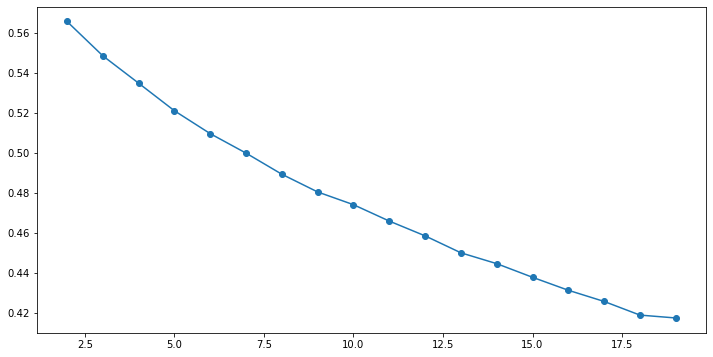

In [228]:
plt.figure(figsize=(12,6))
plt.plot(clusters_df.num_clusters, clusters_df.distortions, marker = "o" )

Now that we have an initial vector representation, we can use it to cluster our documents. We will focus on the K-means algorithm with K starting from 2 and increasing. Next, we can choose the K value that better helps us to spot topics in the final clusters. Doing so, we are impersonating a domain expert that analyzes and evaluates the final subdivision. Remember that, in our context, one clear topic per cluster is the desired outcome.

One simple approach to describe the clusters would exploit wordcloud images. These “clouds” include the most important words in collection of texts for a certain metric. The more a word is significant the bigger it appears in the picture. Fortunately, we already have a “significance” metric: the TFIDF weight of each word. Let’s exploit its very meaning and choose it as the “importance” metric for the wordcloud.

In [229]:
model = KMeans(n_clusters=18, random_state=42)
y_pred = model.fit_predict(X_svd)
cluster_ids = set(y_pred)

df_all = pd.DataFrame()
min_support = 0.3
word_positions = {v: k for k, v in tfidf_vectorizer.vocabulary_.items()}
dist_words = sorted(v for k, v in word_positions.items()) # distinct words in the vocabulary
articles['cluster_id'] = y_pred

### Customer features
* expense in the past N weeks
* mean price / max price -> for customer 
* mean channel_id by each 
* numbers of orders 

In [230]:
customer_price = transactions.groupby(['customer_id'])['price'].mean()/transactions.groupby(['customer_id'])['price'].max()

In [231]:
customers = pd.merge(customer_price,customers, on = ['customer_id'])

In [232]:
customers = customers.rename(columns={"price":"mean_max_price"})

In [233]:
customer_channel = transactions.groupby(['customer_id'])['sales_channel_id'].mean()

In [234]:
customers = pd.merge(customer_channel,customers, on = ['customer_id']).rename(columns={"sales_channel_id":"avg_channel_id"})

In [235]:
# expense in the past N weeks

In [236]:
customer_avg_expense = transactions.groupby(['customer_id'])['price'].mean()

In [237]:
customers = pd.merge(customers, customer_avg_expense, on = ['customer_id']).rename(columns = {'price': 'avg_expense'})

In [238]:
#number of orders

In [239]:
orders_num = transactions.groupby(['customer_id'])['customer_id'].agg('count').reset_index(name='counts')

In [240]:
orders_num

,customer_id,counts
0,28847241659200,5
1,41318098387474,1
2,116809474287335,6
3,200292573348128,19
4,248294615847351,4
...,...,...
437360,18446624797007271432,4
437361,18446630855572834764,5
437362,18446662237889060501,2
437363,18446705133201055310,1


In [241]:
customers = pd.merge(orders_num, customers, on = ['customer_id'])

In [242]:
# expense in the past N weeks

In [243]:
customer_sum_expense = transactions.groupby(['customer_id'])['price'].sum()

In [244]:
customers = pd.merge(customers, customer_sum_expense, on= ['customer_id']).rename(columns = {'price': 'total_expense'})

### Add bestseller information

In [245]:
data = pd.merge(
    data,
    bestsellers_previous_week[['week', 'article_id', 'bestseller_rank']],
    on=['week', 'article_id'],
    how='left'
)

In [246]:
data = data[data.week != data.week.min()]
data.bestseller_rank.fillna(999, inplace=True)

In [247]:
data = pd.merge(data, articles, on='article_id', how='left')
data = pd.merge(data, customers, on='customer_id', how='left')

In [248]:
data.sort_values(['week', 'customer_id'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [249]:
train = data[data.week != test_week]
test = data[data.week==test_week].drop_duplicates(['customer_id', 'article_id', 'sales_channel_id']).copy()

In [250]:
train.bestseller_rank

0           999.0
1           999.0
2           999.0
3             1.0
4             2.0
            ...  
11381607      8.0
11381608      9.0
11381609     10.0
11381610     11.0
11381611     12.0
Name: bestseller_rank, Length: 11381612, dtype: float64

In [251]:
train_baskets = train.groupby(['week', 'customer_id'])['article_id'].count().values

In [252]:
train.groupby(['week', 'customer_id'])['article_id'].agg(list)

week  customer_id         
96    28847241659200          [887770001, 762846001, 829308001, 760084003, 8...
      200292573348128         [880777001, 784332002, 827968001, 599580086, 6...
      248294615847351         [720504008, 471714002, 878987003, 337991001, 7...
      272412481300040         [885077001, 850176003, 875803001, 892970003, 8...
      366493139417506         [822344001, 839287007, 760084003, 866731001, 6...
                                                    ...                        
104   18444954504588539615    [903062001, 807244017, 909370001, 865799006, 9...
      18445164350380731040    [730683050, 909370001, 865799006, 918522001, 9...
      18445340048433064259    [714790028, 906612002, 909370001, 865799006, 9...
      18445641720816255142    [898713001, 909014001, 919365008, 827635001, 8...
      18446737527580148316    [547780001, 763988001, 763988003, 547780040, 9...
Name: article_id, Length: 678433, dtype: object

In [253]:
train

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,bestseller_rank,product_code,prod_name,...,avg_channel_id,mean_max_price,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,avg_expense,total_expense
0,2020-07-26,28847241659200,887770001,0.016932,1.0,96,1.0,999.0,887770,Orvar strap top,...,1.2,0.35781,1.0,1.0,0.0,1.0,21.0,57896.0,0.046085,0.230424
1,2020-07-18,28847241659200,762846001,0.025407,1.0,96,0.0,999.0,762846,Lucy blouse,...,1.2,0.35781,1.0,1.0,0.0,1.0,21.0,57896.0,0.046085,0.230424
2,2020-07-18,28847241659200,829308001,0.033881,1.0,96,0.0,999.0,829308,HAVANA HW cropped,...,1.2,0.35781,1.0,1.0,0.0,1.0,21.0,57896.0,0.046085,0.230424
3,2020-07-26,28847241659200,760084003,0.025094,1.0,96,0.0,1.0,760084,Victorville HW Pull-on TRS,...,1.2,0.35781,1.0,1.0,0.0,1.0,21.0,57896.0,0.046085,0.230424
4,2020-07-26,28847241659200,866731001,0.024919,1.0,96,0.0,2.0,866731,LANA seamless HW tigths,...,1.2,0.35781,1.0,1.0,0.0,1.0,21.0,57896.0,0.046085,0.230424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11381607,2020-09-21,18446737527580148316,918292001,0.041424,2.0,104,0.0,8.0,918292,STRONG HW seamless tights,...,2.0,1.00000,1.0,1.0,0.0,1.0,60.0,96323.0,0.023712,0.094847
11381608,2020-09-21,18446737527580148316,762846027,0.025104,2.0,104,0.0,9.0,762846,Lucy blouse,...,2.0,1.00000,1.0,1.0,0.0,1.0,60.0,96323.0,0.023712,0.094847
11381609,2020-09-21,18446737527580148316,809238005,0.041656,2.0,104,0.0,10.0,809238,Atomic Wrap Sweater,...,2.0,1.00000,1.0,1.0,0.0,1.0,60.0,96323.0,0.023712,0.094847
11381610,2020-09-21,18446737527580148316,673677002,0.024925,2.0,104,0.0,11.0,673677,Henry polo. (1),...,2.0,1.00000,1.0,1.0,0.0,1.0,60.0,96323.0,0.023712,0.094847


In [270]:
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no',  'age',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active','mean_max_price',
 'club_member_status', 'fashion_news_frequency', 'postal_code', 'bestseller_rank','cluster_id','avg_channel_id','avg_expense','total_expense']

In [271]:
# columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
# 'perceived_colour_master_id', 'department_no', 'index_code',
# 'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
# 'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'bestseller_rank']

In [272]:
%%time

train_X = train[columns_to_use]
train_y = train['purchased']

test_X = test[columns_to_use]

CPU times: user 1.2 s, sys: 7.17 s, total: 8.37 s
Wall time: 26.2 s


In [273]:
train_y

0           1.0
1           0.0
2           0.0
3           0.0
4           0.0
           ... 
11381607    0.0
11381608    0.0
11381609    0.0
11381610    0.0
11381611    0.0
Name: purchased, Length: 11381612, dtype: float64

# Model training

In [274]:
from lightgbm.sklearn import LGBMRanker

In [275]:
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=4,
    importance_type='gain',
    verbose=10
)

In [276]:
%%time

ranker = ranker.fit(
    train_X,
    train_y,
    group=train_baskets,
)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.848850
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.104105
[LightGBM] [Debug] init for col-wise cost 0.373454 seconds, init for row-wise cost 0.371310 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.510730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 2087
[LightGBM] [Info] Number of data points in the train set: 11381612, number of used features: 22
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
CPU times: user 28.4 s, sys: 7.79 s, total: 36.2 s
Wall time: 18.1 s


In [277]:
for i in ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], ranker.feature_importances_[i]/ranker.feature_importances_.sum())

bestseller_rank 0.9269851238374939
total_expense 0.034927755696101244
mean_max_price 0.01720149127798692
article_id 0.008565193176854391
avg_channel_id 0.004033644408028161
cluster_id 0.0038130908795765716
garment_group_no 0.0016331311160622142
avg_expense 0.0015809517381306032
product_type_no 0.0005639601876913032
department_no 0.000486344880878578
section_no 0.00012354939431638584
graphical_appearance_no 7.234493301563093e-05
age 1.3418473864089597e-05
club_member_status 0.0
fashion_news_frequency 0.0
Active 0.0
FN 0.0
postal_code 0.0
perceived_colour_master_id 0.0
perceived_colour_value_id 0.0
colour_group_code 0.0
index_group_no 0.0


# Calculate predictions

In [278]:
%time

test['preds'] = ranker.predict(test_X)

c_id2predicted_article_ids = test \
    .sort_values(['customer_id', 'preds'], ascending=False) \
    .groupby('customer_id')['article_id'].apply(list).to_dict()

bestsellers_last_week = \
    bestsellers_previous_week[bestsellers_previous_week.week == bestsellers_previous_week.week.max()]['article_id'].tolist()

CPU times: user 19 µs, sys: 7 µs, total: 26 µs
Wall time: 5.96 µs


In [279]:
test['preds']

11381612    0.400328
11381613   -0.547294
11381614   -0.588470
11381615   -0.588470
11381616   -0.624252
              ...   
23479677   -0.547294
23479678   -0.614038
23479679   -0.623396
23479680    0.491526
23479681   -0.547294
Name: preds, Length: 12098070, dtype: float64

In [280]:
test

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,bestseller_rank,product_code,prod_name,...,mean_max_price,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,avg_expense,total_expense,preds
11381612,2020-09-03,28847241659200,925246001,0.128797,2.0,105,0.0,999.0,925246,Fortune PU,...,0.35781,1.0,1.0,0.0,1.0,21.0,57896.0,0.046085,0.230424,0.400328
11381613,2020-07-18,28847241659200,924243001,0.041535,1.0,105,0.0,1.0,924243,Ohlsson,...,0.35781,1.0,1.0,0.0,1.0,21.0,57896.0,0.046085,0.230424,-0.547294
11381614,2020-07-18,28847241659200,924243002,0.041877,1.0,105,0.0,2.0,924243,Ohlsson,...,0.35781,1.0,1.0,0.0,1.0,21.0,57896.0,0.046085,0.230424,-0.588470
11381615,2020-07-18,28847241659200,918522001,0.041435,1.0,105,0.0,3.0,918522,Jackie cable vest,...,0.35781,1.0,1.0,0.0,1.0,21.0,57896.0,0.046085,0.230424,-0.588470
11381616,2020-07-18,28847241659200,923758001,0.033462,1.0,105,0.0,4.0,923758,Vanessa,...,0.35781,1.0,1.0,0.0,1.0,21.0,57896.0,0.046085,0.230424,-0.624252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23479677,NaT,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,924243001,0.041535,NaN,105,0.0,1.0,924243,Ohlsson,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.547294
23479678,NaT,ffffd9ac14e89946416d80e791d064701994755c3ab686...,751471001,0.033423,NaN,105,0.0,7.0,751471,Pluto RW slacks (1),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.614038
23479679,NaT,ffffd9ac14e89946416d80e791d064701994755c3ab686...,448509014,0.041630,NaN,105,0.0,10.0,448509,Perrie Slim Mom Denim TRS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.623396
23479680,NaT,ffffd9ac14e89946416d80e791d064701994755c3ab686...,918292001,0.041627,NaN,105,0.0,999.0,918292,STRONG HW seamless tights,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.491526


In [281]:
c_id2predicted_article_ids.get(c_id, [])

[]

# Create submission

In [282]:
sub = pd.read_csv('sample_submission.csv')

In [283]:
%%time
preds = []
for c_id in customer_hex_id_to_int(sub.customer_id):
    pred = c_id2predicted_article_ids.get(c_id, [])
    pred = pred + bestsellers_last_week
    preds.append(pred[:12])

CPU times: user 5.02 s, sys: 4.57 s, total: 9.59 s
Wall time: 14.7 s


In [284]:
preds = [' '.join(['0' + str(p) for p in ps]) for ps in preds]
sub.prediction = preds

In [285]:
sub_name = 'basic_model_submission'
sub.to_csv(f'{sub_name}.csv.gz', index=False)

In [286]:
 sub

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0924243001 0924243002 0918522001 09...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0924243001 0924243002 0918522001 0923758001 08...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0924243001 0924243002 0918522001 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0924243001 0924243002 0918522001 0923758001 08...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0927530004 0896152002 0730683050 0791587015 09...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0720125039 0740922009 0791587007 0804992033 05...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0762846031 0924243001 0924243002 0918522001 09...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0924243001 0924243002 0918522001 0915529003 09...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0924243001 0924243002 0918522001 0923758001 08...
